- author: Lee Meng
- category: Machine learning
- date: 2017-09-19 20:30
- title: Simple Image Recognition using NotMNIST dataset
- slug: simple-image-recognition-using-notmnist-dataset
- tags: Python, Matplotlib, Data Preprocessing, Data Cleaning, NotMNIST, Sklearn, Machine Learning, Image Recognition, Udacity
- description: Today we're going to do some simple image recogintion using NotMNIST dataset. But before creating model for prediction, it's more important to explore, clean and normalize our dataset in order to make the learning go smoother when we actually build predictive models.
- summary: Today we're going to do some simple image recogintion using NotMNIST dataset. But before creating model for prediction, it's more important to explore, clean and normalize our dataset in order to make the learning go smoother when we actually build predictive models.

Today we're going to do some simple image recogintion using NotMNIST dataset. But before creating model for prediction, it's more important to explore, clean and normalize our dataset in order to make the learning go smoother when we actually build predictive models.


I motified the [notebook](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/1_notmnist.ipynb) from Udacity's online Deep learning course and the objective of this assignment is to learn about **simple data curation practices**, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

<img src="images/notmnist.png" width="70%"/>


This notebook is mainly foucsing on data preprocessing rather than building models.

## Workflow
- Download / load raw notMNIST dataset
- Drop unreadable images and save the remaining images
- Combine all images and divide it into testing/validation/test set
- Shuffle / Randomize the dataset
- Remove duplicate images appear both in train/test or train/validation set
- Build simple model for image recognition using different size of training data


## After finishing this notebook, we learn
- Use matplotlib to read images, transform them to ndarray and render.
- Identify whether there exist unbalanced problem for the labels of classification .
- Understand why it's important to have both valid and test set.
- Identify the importance of randomizing data for better efficieny when training sequentially.
- Identify duplicate images between training/test set.

---

## Import libraries

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display
from PIL import Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

## Dataset
- Download compressed dataset if the dataset is not available yet

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. **The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples.** Given these sizes, it should be possible to train models quickly on any machine.

In [3]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = './datasets' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./datasets/notMNIST_large.tar.gz
Found and verified ./datasets/notMNIST_small.tar.gz


## Extract the dataset into folders by characters
Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [4]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./datasets/notMNIST_large already present - Skipping extraction of ./datasets/notMNIST_large.tar.gz.
['./datasets/notMNIST_large/A', './datasets/notMNIST_large/B', './datasets/notMNIST_large/C', './datasets/notMNIST_large/D', './datasets/notMNIST_large/E', './datasets/notMNIST_large/F', './datasets/notMNIST_large/G', './datasets/notMNIST_large/H', './datasets/notMNIST_large/I', './datasets/notMNIST_large/J']
./datasets/notMNIST_small already present - Skipping extraction of ./datasets/notMNIST_small.tar.gz.
['./datasets/notMNIST_small/A', './datasets/notMNIST_small/B', './datasets/notMNIST_small/C', './datasets/notMNIST_small/D', './datasets/notMNIST_small/E', './datasets/notMNIST_small/F', './datasets/notMNIST_small/G', './datasets/notMNIST_small/H', './datasets/notMNIST_small/I', './datasets/notMNIST_small/J']


---
Problem 1 - Sample some images in dataset and render them
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

### For each character folder in dataset, randomly choose one picture in it and render them horizontally
Keypoints:
- use ```os.listdir()``` to get list of file in a folder
- use ```mpl.image.imread``` to read in image as ndarray, and use ```plt.imshow``` to render ndarray as images

---

In [5]:
!ls ./datasets/notMNIST_small/

A        B.pickle D        E.pickle G        H.pickle J
A.pickle C        D.pickle F        G.pickle I        J.pickle
B        C.pickle E        F.pickle H        I.pickle


In [6]:
characters = 'abcdefghij'.upper()  # sub folders to choose images from 
image_per_folder = 4 # number of images to show for each folder

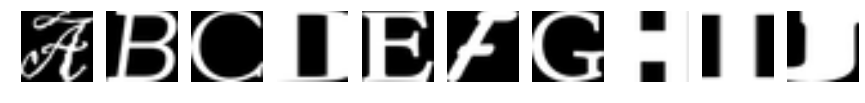

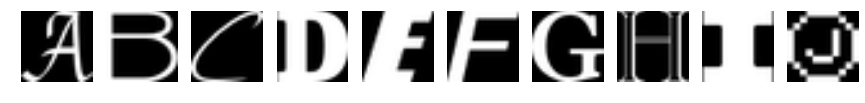

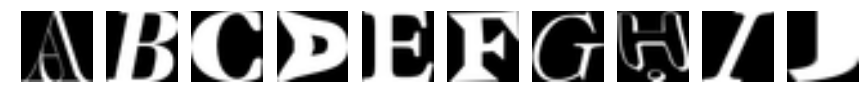

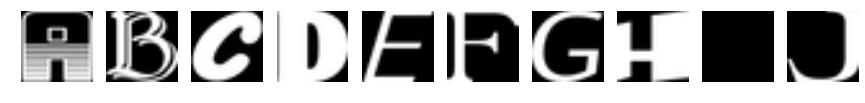

In [7]:
BASE_PATH = './datasets/notMNIST_small/'

list_of_images = []
for _ in range(image_per_folder):
    for char in characters:
        char_folder = BASE_PATH + char + '/'
        images = os.listdir(char_folder)
        image_file_name = images[np.random.randint(len(images))]
        list_of_images.append(char_folder + image_file_name)
    

def showImagesHorizontally(list_of_files):
    from matplotlib.pyplot import figure, imshow, axis
    from matplotlib.image import imread
    
    number_of_files = len(list_of_files)
    num_char = len(characters)
    
    for row in range(int(number_of_files/num_char)):
        fig = figure(figsize=(15, 5))
        
        for i in range(num_char):
            a = fig.add_subplot(1, num_char, i + 1)
            image = imread(list_of_files[row * num_char + i])
            imshow(image, cmap='gray')
            axis('off')

showImagesHorizontally(list_of_images)

## Data curation
- drop unreadable images
- normalization 
- pickle the normalized data by characters / folders 

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, **normalized** to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

### Debugging 
In case of following error occur:
```python
ImportError: Could not import the Python Imaging Library (PIL) required to load image files.
```
Follow these steps:
- pip install pillow
- replace  
```python
from IPython.display import display, Image
```
to
```python
from IPython.display import display 
from PIL import Image
```

Keypoints:
- Normalize image using 
```image_data = (ndimage.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth``` where ```pixel_depth == 255```.


References
- https://stackoverflow.com/questions/41124353/importerror-could-not-import-the-python-imaging-library-pil-required-to-load

In [8]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./datasets/notMNIST_large/A.pickle already present - Skipping pickling.
./datasets/notMNIST_large/B.pickle already present - Skipping pickling.
./datasets/notMNIST_large/C.pickle already present - Skipping pickling.
./datasets/notMNIST_large/D.pickle already present - Skipping pickling.
./datasets/notMNIST_large/E.pickle already present - Skipping pickling.
./datasets/notMNIST_large/F.pickle already present - Skipping pickling.
./datasets/notMNIST_large/G.pickle already present - Skipping pickling.
./datasets/notMNIST_large/H.pickle already present - Skipping pickling.
./datasets/notMNIST_large/I.pickle already present - Skipping pickling.
./datasets/notMNIST_large/J.pickle already present - Skipping pickling.
./datasets/notMNIST_small/A.pickle already present - Skipping pickling.
./datasets/notMNIST_small/B.pickle already present - Skipping pickling.
./datasets/notMNIST_small/C.pickle already present - Skipping pickling.
./datasets/notMNIST_small/D.pickle already present - Skipping pi

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.



### Load  test data and  show normalized images for each pickled dataset
- notMNIST_small only in order to prevent memory-insufficient problem when load all train data

Keypoints:
- use ```pickle.load(open(file_path, 'rb'))``` to load a pickle
- create a figure obj and use ```fig.add_subplot(1, len(images), i+1)``` to add subplot for each image
- render ndarray represent images using ```matplotlob.pyplot.imshow(image)```

---

Number of samples in ./datasets/notMNIST_small/A.pickle: 1872
Number of samples in ./datasets/notMNIST_small/B.pickle: 1873
Number of samples in ./datasets/notMNIST_small/C.pickle: 1873
Number of samples in ./datasets/notMNIST_small/D.pickle: 1873
Number of samples in ./datasets/notMNIST_small/E.pickle: 1873
Number of samples in ./datasets/notMNIST_small/F.pickle: 1872
Number of samples in ./datasets/notMNIST_small/G.pickle: 1872
Number of samples in ./datasets/notMNIST_small/H.pickle: 1872
Number of samples in ./datasets/notMNIST_small/I.pickle: 1872
Number of samples in ./datasets/notMNIST_small/J.pickle: 1872


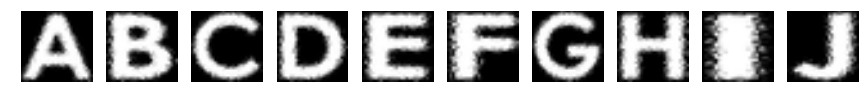

In [9]:
images = []
for file_path in test_datasets:
    data = pickle.load(open(file_path, 'rb'))
    print('Number of samples in {}: {}'.format(file_path, data.shape[0]))
    images.append(data[0, :, :])
  
from matplotlib.pyplot import figure, imshow, axis
fig = figure(figsize=(15, 5))
for i, image in enumerate(images):
    a=fig.add_subplot(1, len(images), i + 1)
    imshow(image, cmap='gray')
    axis('off')

---
Problem 3
---------
We expect the data to be balanced across classes.  
By problem 2 above, we already see the data is balanced in test set, verify data is balanced in train data as well

---

In [10]:
for file_path in train_datasets:
    data = pickle.load(open(file_path, 'rb'))
    print('Number of samples in {}: {}'.format(file_path, data.shape[0]))

Number of samples in ./datasets/notMNIST_large/A.pickle: 52909
Number of samples in ./datasets/notMNIST_large/B.pickle: 52911
Number of samples in ./datasets/notMNIST_large/C.pickle: 52912
Number of samples in ./datasets/notMNIST_large/D.pickle: 52911
Number of samples in ./datasets/notMNIST_large/E.pickle: 52912
Number of samples in ./datasets/notMNIST_large/F.pickle: 52912
Number of samples in ./datasets/notMNIST_large/G.pickle: 52912
Number of samples in ./datasets/notMNIST_large/H.pickle: 52912
Number of samples in ./datasets/notMNIST_large/I.pickle: 52912
Number of samples in ./datasets/notMNIST_large/J.pickle: 52911


## Merge seperate character dataset together (for all training/test/valid)

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of **integers 0 through 9.**

Also create a validation dataset for hyperparameter tuning.

Keypoints:
- Why we need vaild/test set? Our goal is to make sure the model we train can generalize to brand-new data. If we only divide the whole dataset into training/test set and try to get the best model by tuning parameters on test set, chances are that we actully give the model 'hints' on training set by our eyes. Because eventually, the best model will use the parameters incorporating our knowledge about training dataset, and when the very brand-new data comes, our model can't actually generalize to it and make wrong predictions. So we have to use vaild/dev set to tune our model, and only test the performance on test set to simulate model's 'real-world' performance after deploying it.

In [11]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


## Randomize data
Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match. The purpose of randomizing data is to perserve the assumption that we get the data randomly as predict phase. We don't want to train models sequantially on training instances like AAA ... BBB ... CCC. 

Keypoints:
- train set and test set should apply the same shuffle 
```python
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
```
- Although we do only one randomization here, we may do it multiple times when we are going to use the same dataset many times.

In [12]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4 - Sanity check after shuffling dataset
---------
Convince yourself that the data is still good after shuffling!  
Randomly sample data instances to make sure X is corresponding to y for both training and test set after shuffling.  
Keypoints:
- label is start from 0 to 9 for A to J

---

Training dataset:


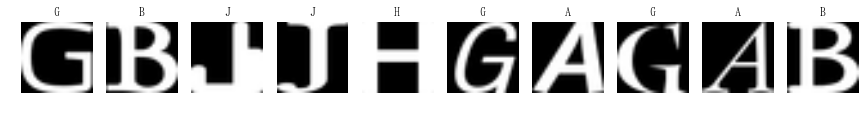

In [13]:
lookup_labels = {k: v for (k, v) in zip(np.arange(10), 'ABCDEFGHIJ')}
def sanity_check(X, y, s=None):
    print(s)
    m1, m2 = X.shape[0], y.shape[0]
    assert(m1 == m2)

    # randomly choose 10 images to check label
    indices = np.random.randint(0, m1, size=10)
    
    fig = plt.figure(figsize=(15, 5))

    for i, idx in enumerate(indices):
        fig.add_subplot(1, len(indices), i + 1)
        plt.imshow(X[idx, :, :], cmap='gray')
        plt.title(lookup_labels[y[idx]])
        plt.axis('off')
    
sanity_check(train_dataset, train_labels, 'Training dataset:')

Test dataset:


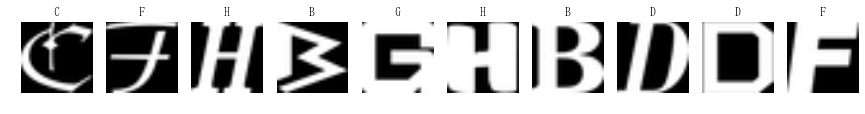

In [14]:
sanity_check(test_dataset, test_labels, 'Test dataset:')

## Serialize dataset for later usage
Everything looks good, finally, let's save the data for later reuse:

In [15]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [16]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800503


---
Problem 5 - Remove overlapping samples in test/valid set
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is **never** an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

### Find duplicate images in test set
I used Cosine Similarity to measure whether image A in training set is identical to those image B in valid/test set.

<img src="images/cosine_sim.png" width="50%"/>

As formula suggested, I reshape every image in training set into column vectors, and do the same for images in valid/test set and compute similarity between the vectors. Although we can compute cosine similarity for every (train image vector, test image vector) explicitly, it's better to use vectorization to speed up computation since that we have 200,000 training images and 10,000 valid/test images. (Although it still take about 10 minutes to run in my computer)

Keypoints:
- Vectorize both training/test images and compute cosine similarity using ```cosine_sim = np.inner(X, Y) / np.inner(np.abs(X), np.abs(Y))```. The output matrix cosine_sim will be shape (m1, m2) where m1 is the number of training images and m2 the number of test images. cosine_matrix(i, j) mean the cosine similarity between training image #i and test image #j.

Number of duplicates in test dataset: 1768
CPU times: user 5min 11s, sys: 4min 17s, total: 9min 29s
Wall time: 7min 40s


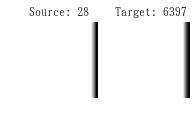

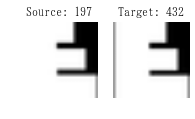

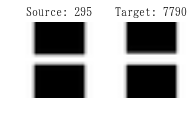

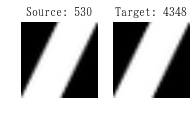

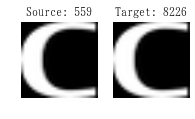

In [17]:
%%time
def get_duplicate_data(source_dataset, target_dataset, threshold=1, num_duplicate_to_show=0):
    X = source_dataset.reshape(source_dataset.shape[0], -1)
    Y = target_dataset.reshape(target_dataset.shape[0], -1)
    assert(X.shape[1] == Y.shape[1])
    
    dim = X.shape[1]
    cosine_sim = np.inner(X, Y) / np.inner(np.abs(X), np.abs(Y))
    assert(cosine_sim.shape == (X.shape[0], Y.shape[0]))
    
    # for each image in training set, find corresponding duplicate in test/valid set
    dup_target_indices = []
    show_duplicate_counter = 0
    for source_idx in range(cosine_sim.shape[0]):
        dup_indices = list(np.where(cosine_sim[source_idx, :] >= threshold)[0])
    
        # render duplicate images when is available. may omit if visual output is not required
        if dup_indices and num_duplicate_to_show and (show_duplicate_counter < num_duplicate_to_show):
            # show only non-redudent duplicate images
            for i in dup_indices:
                if i in dup_target_indices:
                    dup_indices.remove(i)
            if not dup_indices: continue
            
            if len(dup_indices) == 1:
            
                fig = plt.figure(figsize=(3, 15))
                fig.add_subplot(1, len(dup_indices) + 1, 1)
                plt.imshow(source_dataset[source_idx, :, :], cmap='gray')
                plt.title('Source: ' + str(source_idx))
                plt.axis('off')
            
            
                for i, target_idx in enumerate(dup_indices):
                    fig.add_subplot(1, len(dup_indices) + 1, i + 2)
                    plt.imshow(target_dataset[target_idx, :, :], cmap='gray')
                    plt.title('Target: ' + str(target_idx))
                    plt.axis('off')

                show_duplicate_counter += 1
        
        dup_target_indices.extend(dup_indices)
    return list(set(dup_target_indices))
        
    
dup_indices_test = get_duplicate_data(train_dataset, test_dataset, num_duplicate_to_show=5)
print('Number of duplicates in test dataset: {}'.format(len(dup_indices_test)))


### Duplicate images in validation set

Number of duplicates in validation dataset: 1507
CPU times: user 7min 52s, sys: 5min 7s, total: 12min 59s
Wall time: 8min 57s


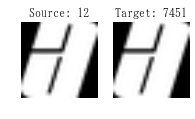

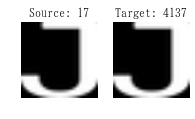

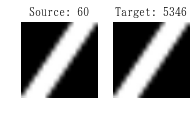

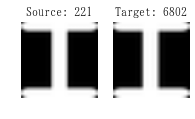

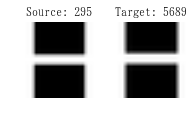

In [18]:
%%time
dup_indices_valid = get_duplicate_data(train_dataset, valid_dataset, num_duplicate_to_show=5)
print('Number of duplicates in validation dataset: {}'.format(len(dup_indices_valid)))

### Serialize sanitized dataset for later model performance comparison
- Remove duplicates in test/valid set
- Save dataset

Keypoints:
- Do the same operation to both X and y

In [19]:
print("Number of duplicate images in test set: {}".format(len(dup_indices_test)))
print("Number of duplicate images in valid set: {}".format(len(dup_indices_valid)))

Number of duplicate images in test set: 1768
Number of duplicate images in valid set: 1507


In [20]:
non_duplicate_indices = [i for i in range(test_dataset.shape[0]) if not i in dup_indices_test]
sanitized_test_dataset = test_dataset[non_duplicate_indices, :, :]
sanitized_test_labels = test_labels[non_duplicate_indices]

non_duplicate_indices = [i for i in range(valid_dataset.shape[0]) if not i in dup_indices_valid]
sanitized_valid_dataset = valid_dataset[non_duplicate_indices, :, :]
sanitized_valid_labels = valid_labels[non_duplicate_indices]

In [21]:
pickle_file = os.path.join(data_root, 'notMNIST_sanitized.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': sanitized_valid_dataset,
    'valid_labels': sanitized_valid_labels,
    'test_dataset': sanitized_test_dataset,
    'test_labels': sanitized_test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [22]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 680517003


---
Problem 6 - Build naive classifier using logistic regression
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

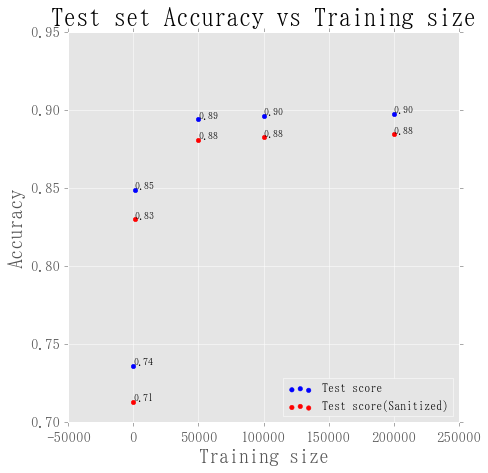

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
plt.style.use('ggplot')
np.random.seed(42)
train_sizes = [100, 1000, 50000, 100000, 200000]

# train models using different size of training set
test_scores, test_scores_sanitized = [[] for _ in range(2)]
for train_size in train_sizes:
    # random choose #train_size of training instances
    indices = np.random.randint(0, train_dataset.shape[0], train_size)
    
    # reshape images to (train_size, dim * dim) for easier processing
    X = train_dataset[indices, :, :]\
        .reshape(-1, train_dataset.shape[1] * train_dataset.shape[2])
    y = train_labels[indices]
        
    # train model
    clf = (LogisticRegression(random_state=10, solver='lbfgs', multi_class='multinomial')
                  .fit(X, y))
    
    # test on original test set and the sanitized one
    y_pred = clf.predict(test_dataset.reshape(test_dataset.shape[0], -1))
    y_pred_sanitized = clf.predict(sanitized_test_dataset.reshape(sanitized_test_dataset.shape[0], -1))

    test_score = accuracy_score(y_pred, test_labels)
    test_score_sanitized = accuracy_score(y_pred_sanitized, sanitized_test_labels)
    test_scores.append(test_score)
    test_scores_sanitized.append(test_score_sanitized)

    
    
#     print(classification_report(test_labels, y_pred))
#     print(accuracy_score(test_labels, y_pred))

    
plt.figure(figsize=(7, 7))
plt.xlabel('Training size', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
for x, y in zip(train_sizes, test_scores):
    plt.text(x + 50, y, '{:.2f}'.format(y))
for x, y in zip(train_sizes, test_scores_sanitized):
    plt.text(x + 50, y, '{:.2f}'.format(y))
    
plt.scatter(train_sizes, test_scores, label='Test score', color='blue');
plt.scatter(train_sizes, test_scores_sanitized, label='Test score(Sanitized)', color='red');
plt.legend(loc=4)
plt.title('Test set Accuracy vs Training size', fontsize=25);

As show above, there are seveal things worth mentioning:
- Our model became better on classifiying labels in test set by using more data in training phase. By training a simple logistic regression model on all available training data, we can expect to get about 90% accuracy. 


- There is a performance gap (2~3% on accuracy) between test set with duplicate images and the one without. Depends on our application, choose the one which best fit our use case.


- Notice that we just want to have a off-the-shelf model quickly, so we don't even tune hyper-parameters using validation set. We may be able to further improve model's predictive performance by tuning hyper-parameters or using Neural Network in another notebook.